<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/Autoencoders/CNN/Simple%20Convolutional%20Autoencoder/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import torch
import numpy as np
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

## Transform

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

## Load Data

In [3]:
# load the training and test datasets
train_data = CIFAR10(root='data', train=True,download=True, transform=transform)
test_data = CIFAR10(root='data', train=False,download=True, transform=transform)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Batching

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1000

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

## Configure GPU

In [6]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
gpu = torch.device('cuda:0')

1
Tesla T4


## Model Class

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1))
        
        self.fc_encoder = nn.Sequential(
            nn.Linear(128*4*4,1024),
            nn.LeakyReLU(0.1))
        
        self.fc_decoder = nn.Sequential(
            nn.Linear(1024,128*4*4),
            nn.LeakyReLU(0.1))
        
        self.conv_decoder = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU())

    def forward(self, x):
        x = self.conv_encoder(x)
        x = x.view(-1, 128*4*4)
        x = self.fc_encoder(x)
        x = self.fc_decoder(x)
        x = x.view(-1, 128,4,4)
        x = self.conv_decoder(x)
        return x

In [9]:
# initialize the NN
model = autoencoder()
model = model.to(gpu)
print(model)

autoencoder(
  (conv_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
  )
  (fc_encoder): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (fc_decoder): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv_decoder): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Upsample(scale_factor=2.0, mode=bilinear)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): Upsample(scale_fac

In [10]:
import copy

In [11]:
print(model.conv_encoder[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


In [12]:
init_weights = copy.deepcopy(model.conv_encoder[0].weight.data)

In [13]:
import torch.optim as optim

In [14]:
epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainLoss = []

In [15]:
import time
import tqdm

## Train The Model

In [16]:
for epoch in range(epochs):  # loop over the dataset multiple times
    epochStart = time.time()
    runningLoss = 0.0
    for data in tqdm.tqdm_notebook(train_loader):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(gpu)
        
        # zeroes the gradient buffers of all parameters
        optimizer.zero_grad()  
        
        # forward pass
        outputs = model(inputs) 

        # calculate loss
        loss = criterion(outputs, inputs) 

        #backpropagate the loss  
        loss.backward()       

        # update the weights in one step
        optimizer.step()
        
        runningLoss += loss.item()
    trainLoss.append((runningLoss/(60000/batch_size)))
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,epochs,runningLoss/(60000/batch_size),epochEnd//60,epochEnd%60))   
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



Iteration: 1 /10  ;  Training Loss: 0.110657 ; Time consumed: 0m 17s 



Iteration: 2 /10  ;  Training Loss: 0.033821 ; Time consumed: 0m 17s 



Iteration: 3 /10  ;  Training Loss: 0.026766 ; Time consumed: 0m 17s 



Iteration: 4 /10  ;  Training Loss: 0.022660 ; Time consumed: 0m 17s 



Iteration: 5 /10  ;  Training Loss: 0.022304 ; Time consumed: 0m 18s 



Iteration: 6 /10  ;  Training Loss: 0.019027 ; Time consumed: 0m 17s 



Iteration: 7 /10  ;  Training Loss: 0.017072 ; Time consumed: 0m 17s 



Iteration: 8 /10  ;  Training Loss: 0.018194 ; Time consumed: 0m 17s 



Iteration: 9 /10  ;  Training Loss: 0.015524 ; Time consumed: 0m 17s 



Iteration: 10 /10  ;  Training Loss: 0.015075 ; Time consumed: 0m 18s 
Finished Training


In [17]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Training loss')

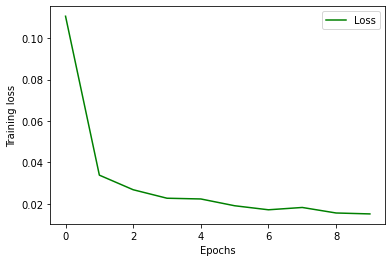

In [18]:
fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss')

## Weights Visualization

In [19]:
from torchvision.utils import make_grid

In [20]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [21]:
trained_weights = copy.deepcopy(model.conv_encoder[0].weight.data)
init_weights = init_weights.view(64,3,3,3)
trained_weights = trained_weights.view(64,3,3,3)

In [22]:
init_weights = init_weights.cpu()
trained_weights = trained_weights.cpu()
d_weights = init_weights - trained_weights 

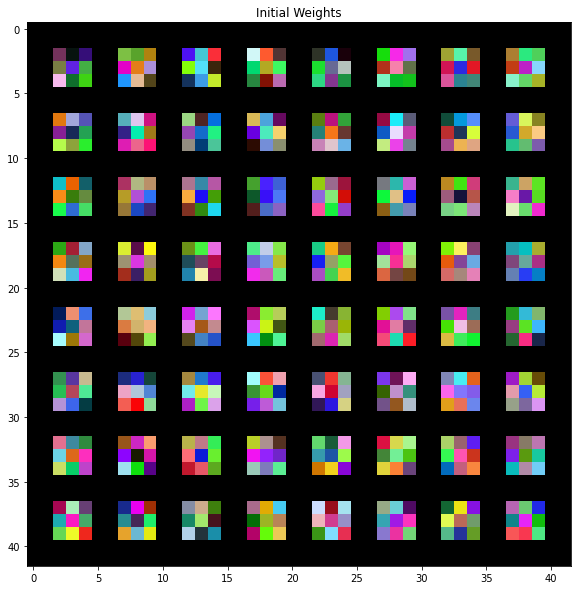

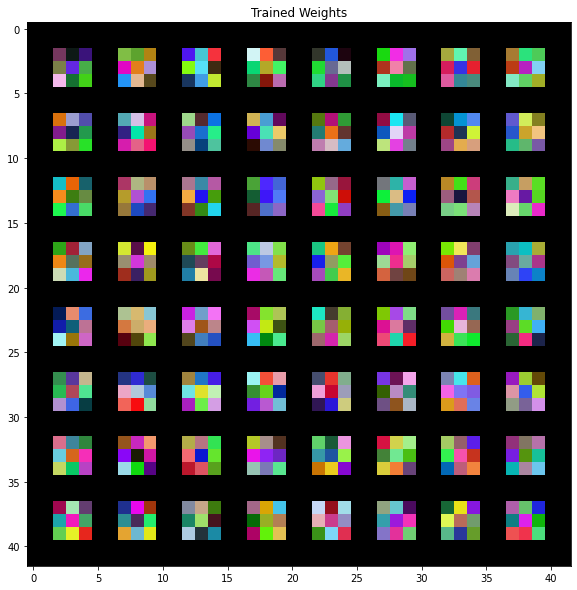

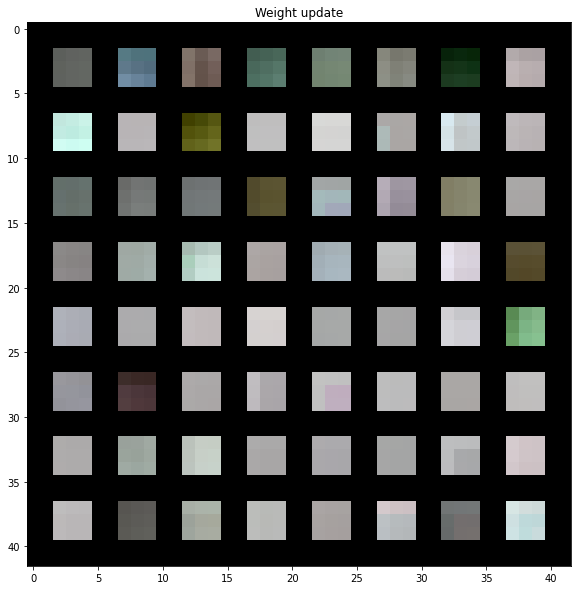

In [23]:
imshow(make_grid(init_weights,nrow=8,normalize=True),'Initial Weights')
imshow(make_grid(trained_weights,nrow=8,normalize=True),'Trained Weights')
imshow(make_grid(d_weights,nrow=8,normalize=True), 'Weight update')

## Modifying the autoencoder for classification

In [24]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = model.conv_encoder
        self.fc1 = model.fc_encoder
        self.fc2 = nn.Sequential(nn.Linear(1024, 10))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128*4*4)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [25]:
net = Model()
net = net.to(gpu)
print(net)

Model(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [26]:
# Copying initial weights  for visualization
cll_weights = copy.deepcopy(net.conv[0].weight.data)

In [27]:
iterations = 10
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
trainLoss = []
testacc = []

## Train the model

In [28]:
for epoch in range(iterations):  # loop over the dataset multiple times
    epochStart = time.time()
    runningLoss = 0.0
    net.train()
    for data in tqdm.tqdm_notebook(train_loader):
        # get the inputs
        inputs, labels = data
        
        inputs, labels = inputs.to(gpu), labels.to(gpu)

        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        
        runningLoss += loss.item()
        correct = 0
        total = 0
    
    net.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(gpu), labels.to(gpu)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    trainLoss.append((runningLoss/(60000/batch_size)))
    testacc.append(100 * float(correct) /float(total))
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,runningLoss/(60000/batch_size),100 * float(correct) /float(total),epochEnd//60,epochEnd%60))

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Iteration: 1 /10  ;  Training Loss: 1.487465 ; Testing Acc: 45.080 ; Time consumed: 0m 10s 



Iteration: 2 /10  ;  Training Loss: 1.199683 ; Testing Acc: 52.250 ; Time consumed: 0m 10s 



Iteration: 3 /10  ;  Training Loss: 1.072855 ; Testing Acc: 55.380 ; Time consumed: 0m 9s 



Iteration: 4 /10  ;  Training Loss: 0.970994 ; Testing Acc: 58.180 ; Time consumed: 0m 10s 



Iteration: 5 /10  ;  Training Loss: 0.894143 ; Testing Acc: 58.940 ; Time consumed: 0m 10s 



Iteration: 6 /10  ;  Training Loss: 0.824163 ; Testing Acc: 61.140 ; Time consumed: 0m 9s 



Iteration: 7 /10  ;  Training Loss: 0.754860 ; Testing Acc: 61.380 ; Time consumed: 0m 9s 



Iteration: 8 /10  ;  Training Loss: 0.700317 ; Testing Acc: 63.620 ; Time consumed: 0m 9s 



Iteration: 9 /10  ;  Training Loss: 0.657518 ; Testing Acc: 63.190 ; Time consumed: 0m 9s 



Iteration: 10 /10  ;  Training Loss: 0.590501 ; Testing Acc: 64.530 ; Time consumed: 0m 9s 
Finished Training


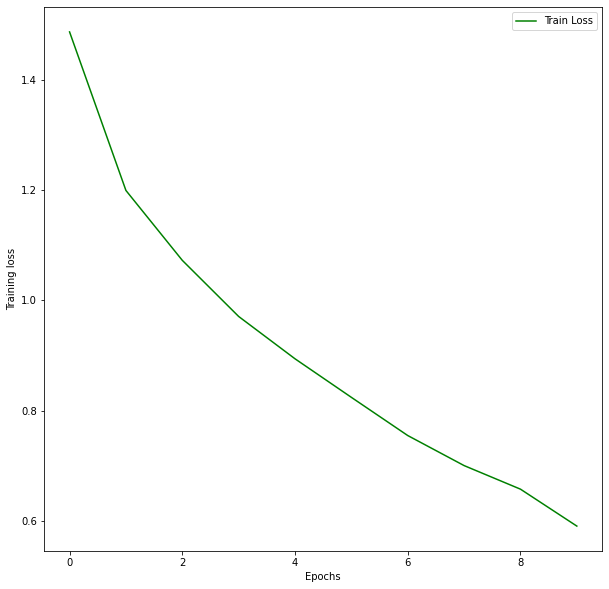

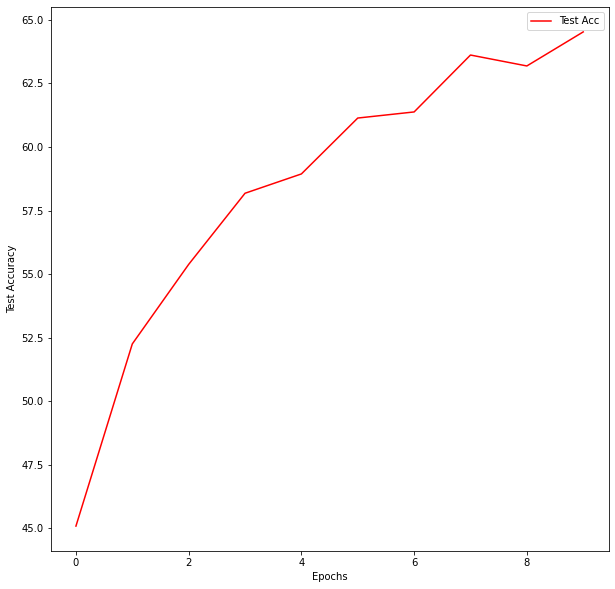

In [29]:
fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Train Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss') 

fig = plt.figure()        
plt.plot(range(epoch+1),testacc,'r-',label='Test Acc')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.show()

##Encoder Weights Visualization

In [30]:
cll_weights = cll_weights.view(64,3,3,3)
cll_weights_ft = copy.deepcopy(net.conv[0].weight.data)
cll_weights_ft = cll_weights_ft.view(64,3,3,3)

In [31]:
cll_weights = cll_weights.cpu()
cll_weights_ft = cll_weights_ft.cpu()
d_weights = cll_weights-cll_weights_ft

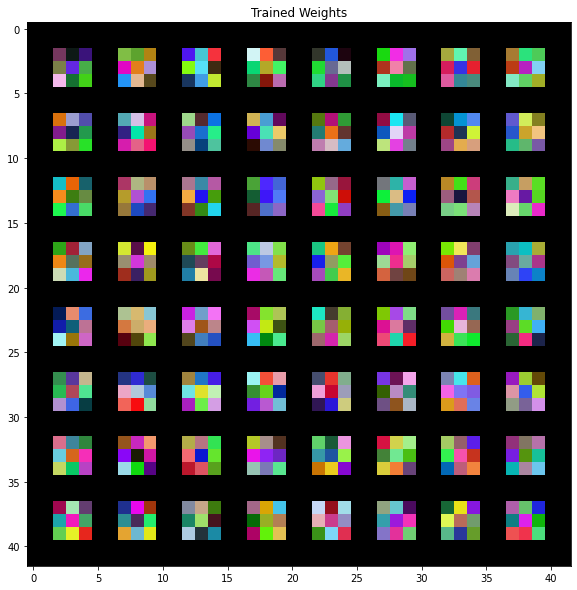

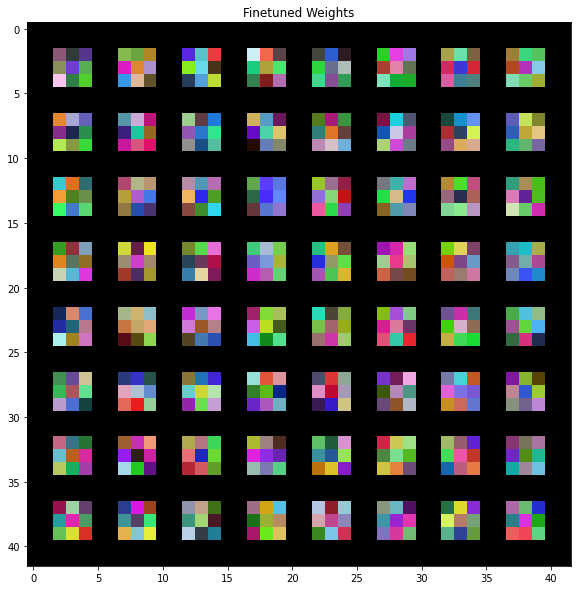

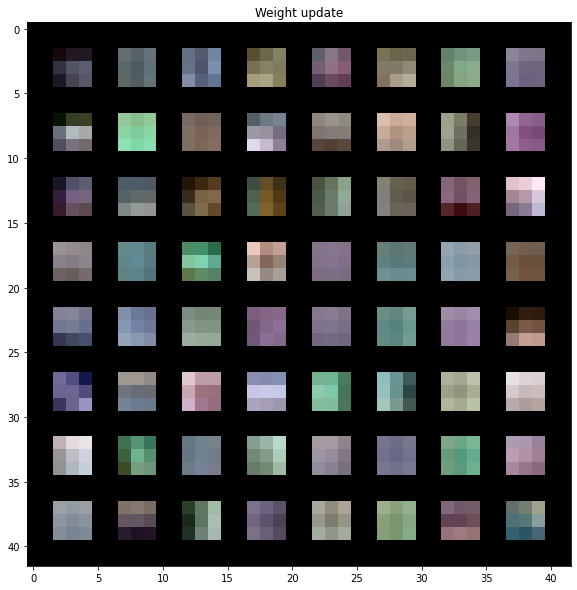

In [32]:
imshow(make_grid(cll_weights,nrow=8,normalize=True),'Trained Weights')
imshow(make_grid(cll_weights_ft,nrow=8,normalize=True),'Finetuned Weights')
imshow(make_grid(d_weights,nrow=8,normalize=True), 'Weight update')

## Performance of different Classes

In [33]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        outputs = net(images.to(gpu))
        _, predicted = torch.max(outputs.data, 1)
        
        predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += float(c[i])
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * float(class_correct[i]) / float(class_total[i])))

Accuracy of plane : 68.400000 %
Accuracy of   car : 79.700000 %
Accuracy of  bird : 43.800000 %
Accuracy of   cat : 42.000000 %
Accuracy of  deer : 53.200000 %
Accuracy of   dog : 67.400000 %
Accuracy of  frog : 69.300000 %
Accuracy of horse : 71.100000 %
Accuracy of  ship : 81.500000 %
Accuracy of truck : 68.900000 %
